In [75]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
import requests
import os
import torch
from PIL import Image, ImageDraw
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import torchvision.transforms as T

import sys

sys.path.append("..")

In [77]:
tokens = {}
with open("/home/dbogdoll/mcity_data_engine/.secret", "r") as file:
    for line in file:
        key, value = line.strip().split("=")
        tokens[key] = value

os.environ["HF_TOKEN"] = tokens["HF_TOKEN"]

In [78]:
import fiftyone as fo
from fiftyone.utils.huggingface import load_from_hub
from utils.data_loader import FiftyOneTorchDatasetCOCO, TorchToHFDatasetCOCO


try:
    dataset_v51 = load_from_hub("dbogdollumich/mcity_fisheye_v51", max_samples=16)
except:
    dataset_v51 = fo.load_dataset("dbogdollumich/mcity_fisheye_v51")
pytorch_dataset = FiftyOneTorchDatasetCOCO(dataset_v51)
pt_to_hf_converter = TorchToHFDatasetCOCO(pytorch_dataset)
hf_dataset = pt_to_hf_converter.convert()

Loading dataset


Processing Voxel51 dataset: 100%|██████████| 16/16 [00:00<00:00, 211.40it/s]


Generating train split: 0 examples [00:00, ? examples/s]

In [79]:
from torch.utils.data import DataLoader


def zeroshot_collate_fn(batch):
    return list(zip(*batch))


data_loader = DataLoader(
    pytorch_dataset,
    batch_size=2,
    num_workers=8,
    pin_memory=True,
    collate_fn=zeroshot_collate_fn,
)

In [80]:
batch = next(iter(data_loader))
print(batch)
item = batch[0]
print(item)
image = item[0]

[[tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
    

In [81]:
classes = [
    "car",
    "truck",
    "bus",
    "trailer",
    "motorbike/cycler",
    "pedestrian",
    "van",
    "pickup",
]

processed_classes = [part for classname in classes for part in classname.split("/")]
class_parts_dict = {
    part: classname for classname in classes for part in classname.split("/")
}

classes = processed_classes
print(classes)

['car', 'truck', 'bus', 'trailer', 'motorbike', 'cycler', 'pedestrian', 'van', 'pickup']


In [82]:
model_id = "IDEA-Research/grounding-dino-tiny"
device = "cuda"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

text = ". ".join(classes) + "."
print(text)

tokenized_text = processor.tokenizer(text, return_tensors="pt")
print(tokenized_text)
inputs = processor(images=image, text=text, return_tensors="pt").to(device)
print(inputs)
with torch.no_grad():
    outputs = model(**inputs)

target_size = [tuple(image.shape[1:])]

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.2,
    text_threshold=0.2,
    target_sizes=target_size
)
print(results)

car. truck. bus. trailer. motorbike. cycler. pedestrian. van. pickup.
{'input_ids': tensor([[  101,  2482,  1012,  4744,  1012,  3902,  1012,  9117,  1012,  5013,
          5638,  3489,  1012,  5402,  2099,  1012, 14662,  1012,  3158,  1012,
         15373,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
{'input_ids': tensor([[  101,  2482,  1012,  4744,  1012,  3902,  1012,  9117,  1012,  5013,
          5638,  3489,  1012,  5402,  2099,  1012, 14662,  1012,  3158,  1012,
         15373,  1012,   102]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0'), 'pixel_values': tensor([[[[-2.1179, -2.1179, -2.1179,  ...,

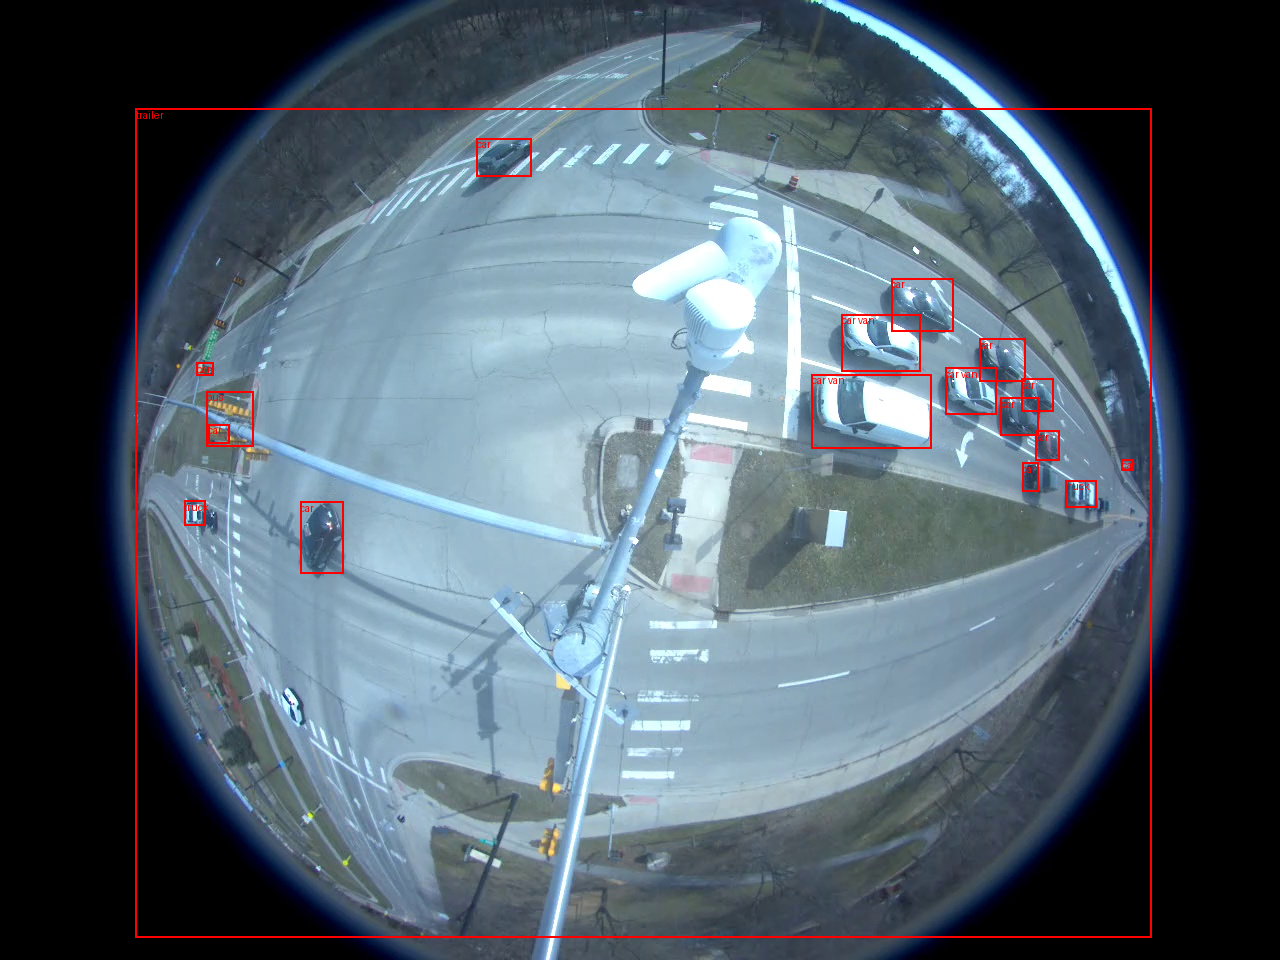

In [83]:
# Assuming 'results' contains the bounding boxes and labels
boxes = results[0]["boxes"]
labels = results[0]["labels"]

image_pil = T.ToPILImage()(image)

# Draw bounding boxes on the image
draw = ImageDraw.Draw(image_pil)
for box, label in zip(boxes, labels):
    draw.rectangle(box.tolist(), outline="red", width=2)
    draw.text((box[0], box[1]), label, fill="red")

# Display the image
display(image_pil)

In [84]:
batch_tokenized_text = [tokenized_text] * data_loader.batch_size

print(batch_tokenized_text)
batch_text = [text] * data_loader.batch_size
print(batch_text)

[{'input_ids': tensor([[  101,  2482,  1012,  4744,  1012,  3902,  1012,  9117,  1012,  5013,
          5638,  3489,  1012,  5402,  2099,  1012, 14662,  1012,  3158,  1012,
         15373,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}, {'input_ids': tensor([[  101,  2482,  1012,  4744,  1012,  3902,  1012,  9117,  1012,  5013,
          5638,  3489,  1012,  5402,  2099,  1012, 14662,  1012,  3158,  1012,
         15373,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}]
['car. truck. bus. trailer. motorbike. cycler. pedestrian. van. pickup.', 'car. truck. bus. trailer. motorbike. cycler. pedestrian. van. pickup.']


In [85]:
import os
from tqdm import tqdm

batch_text = [text] * data_loader.batch_size
print(batch_text)

os.environ["TOKENIZERS_PARALLELISM"] = "true"
for images, targets in tqdm(data_loader):
    inputs = processor(text=batch_text, images=images, return_tensors="pt").to(device)
    print("Inputs shape (first run):", {k: v.shape for k, v in inputs.items()})
    with torch.no_grad():
        outputs = model(**inputs)
    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        box_threshold=0.2,
    )

tokenized_texts = processor.tokenizer(
    batch_text,
    padding="max_length",
    return_tensors="pt",
    max_length=256,  # Adjust max_length to match vision hidden state
).to(device)
print("Tokenized texts shape:", {k: v.shape for k, v in tokenized_texts.items()})

for images, targets in tqdm(data_loader):
    inputs = processor(text=None, images=images, return_tensors="pt").to(device)
    inputs.update(tokenized_texts)
    print("Inputs shape (second run):", {k: v.shape for k, v in inputs.items()})
    with torch.no_grad():
        outputs = model(**inputs)
    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        box_threshold=0.2,
    )

['car. truck. bus. trailer. motorbike. cycler. pedestrian. van. pickup.', 'car. truck. bus. trailer. motorbike. cycler. pedestrian. van. pickup.']


 12%|█▎        | 1/8 [00:00<00:02,  2.63it/s]

Inputs shape (first run): {'input_ids': torch.Size([2, 23]), 'token_type_ids': torch.Size([2, 23]), 'attention_mask': torch.Size([2, 23]), 'pixel_values': torch.Size([2, 3, 800, 1066]), 'pixel_mask': torch.Size([2, 800, 1066])}
Inputs shape (first run): {'input_ids': torch.Size([2, 23]), 'token_type_ids': torch.Size([2, 23]), 'attention_mask': torch.Size([2, 23]), 'pixel_values': torch.Size([2, 3, 800, 1066]), 'pixel_mask': torch.Size([2, 800, 1066])}


 38%|███▊      | 3/8 [00:00<00:01,  4.14it/s]

Inputs shape (first run): {'input_ids': torch.Size([2, 23]), 'token_type_ids': torch.Size([2, 23]), 'attention_mask': torch.Size([2, 23]), 'pixel_values': torch.Size([2, 3, 800, 1066]), 'pixel_mask': torch.Size([2, 800, 1066])}


 50%|█████     | 4/8 [00:00<00:00,  4.41it/s]

Inputs shape (first run): {'input_ids': torch.Size([2, 23]), 'token_type_ids': torch.Size([2, 23]), 'attention_mask': torch.Size([2, 23]), 'pixel_values': torch.Size([2, 3, 800, 1066]), 'pixel_mask': torch.Size([2, 800, 1066])}


 62%|██████▎   | 5/8 [00:01<00:00,  4.58it/s]

Inputs shape (first run): {'input_ids': torch.Size([2, 23]), 'token_type_ids': torch.Size([2, 23]), 'attention_mask': torch.Size([2, 23]), 'pixel_values': torch.Size([2, 3, 800, 1066]), 'pixel_mask': torch.Size([2, 800, 1066])}


 75%|███████▌  | 6/8 [00:01<00:00,  4.69it/s]

Inputs shape (first run): {'input_ids': torch.Size([2, 23]), 'token_type_ids': torch.Size([2, 23]), 'attention_mask': torch.Size([2, 23]), 'pixel_values': torch.Size([2, 3, 800, 1066]), 'pixel_mask': torch.Size([2, 800, 1066])}


 88%|████████▊ | 7/8 [00:01<00:00,  4.58it/s]

Inputs shape (first run): {'input_ids': torch.Size([2, 23]), 'token_type_ids': torch.Size([2, 23]), 'attention_mask': torch.Size([2, 23]), 'pixel_values': torch.Size([2, 3, 800, 1066]), 'pixel_mask': torch.Size([2, 800, 1066])}


100%|██████████| 8/8 [00:01<00:00,  4.21it/s]


Inputs shape (first run): {'input_ids': torch.Size([2, 23]), 'token_type_ids': torch.Size([2, 23]), 'attention_mask': torch.Size([2, 23]), 'pixel_values': torch.Size([2, 3, 800, 1066]), 'pixel_mask': torch.Size([2, 800, 1066])}
Tokenized texts shape: {'input_ids': torch.Size([2, 256]), 'token_type_ids': torch.Size([2, 256]), 'attention_mask': torch.Size([2, 256])}


 12%|█▎        | 1/8 [00:00<00:02,  2.49it/s]

Inputs shape (second run): {'pixel_values': torch.Size([2, 3, 800, 1066]), 'pixel_mask': torch.Size([2, 800, 1066]), 'input_ids': torch.Size([2, 256]), 'token_type_ids': torch.Size([2, 256]), 'attention_mask': torch.Size([2, 256])}


 25%|██▌       | 2/8 [00:00<00:01,  3.33it/s]

Inputs shape (second run): {'pixel_values': torch.Size([2, 3, 800, 1066]), 'pixel_mask': torch.Size([2, 800, 1066]), 'input_ids': torch.Size([2, 256]), 'token_type_ids': torch.Size([2, 256]), 'attention_mask': torch.Size([2, 256])}


 38%|███▊      | 3/8 [00:00<00:01,  3.76it/s]

Inputs shape (second run): {'pixel_values': torch.Size([2, 3, 800, 1066]), 'pixel_mask': torch.Size([2, 800, 1066]), 'input_ids': torch.Size([2, 256]), 'token_type_ids': torch.Size([2, 256]), 'attention_mask': torch.Size([2, 256])}


 50%|█████     | 4/8 [00:01<00:01,  3.96it/s]

Inputs shape (second run): {'pixel_values': torch.Size([2, 3, 800, 1066]), 'pixel_mask': torch.Size([2, 800, 1066]), 'input_ids': torch.Size([2, 256]), 'token_type_ids': torch.Size([2, 256]), 'attention_mask': torch.Size([2, 256])}


 62%|██████▎   | 5/8 [00:01<00:00,  4.09it/s]

Inputs shape (second run): {'pixel_values': torch.Size([2, 3, 800, 1066]), 'pixel_mask': torch.Size([2, 800, 1066]), 'input_ids': torch.Size([2, 256]), 'token_type_ids': torch.Size([2, 256]), 'attention_mask': torch.Size([2, 256])}


 75%|███████▌  | 6/8 [00:01<00:00,  4.16it/s]

Inputs shape (second run): {'pixel_values': torch.Size([2, 3, 800, 1066]), 'pixel_mask': torch.Size([2, 800, 1066]), 'input_ids': torch.Size([2, 256]), 'token_type_ids': torch.Size([2, 256]), 'attention_mask': torch.Size([2, 256])}


 88%|████████▊ | 7/8 [00:01<00:00,  4.22it/s]

Inputs shape (second run): {'pixel_values': torch.Size([2, 3, 800, 1066]), 'pixel_mask': torch.Size([2, 800, 1066]), 'input_ids': torch.Size([2, 256]), 'token_type_ids': torch.Size([2, 256]), 'attention_mask': torch.Size([2, 256])}


100%|██████████| 8/8 [00:02<00:00,  4.26it/s]

Inputs shape (second run): {'pixel_values': torch.Size([2, 3, 800, 1066]), 'pixel_mask': torch.Size([2, 800, 1066]), 'input_ids': torch.Size([2, 256]), 'token_type_ids': torch.Size([2, 256]), 'attention_mask': torch.Size([2, 256])}


100%|██████████| 8/8 [00:02<00:00,  3.92it/s]


In [86]:
import os

tokens = {}
with open("/home/dbogdoll/mcity_data_engine/.secret", "r") as file:
    for line in file:
        key, value = line.strip().split("=")
        tokens[key] = value

os.environ["HF_TOKEN"] = tokens["HF_TOKEN"]

In [87]:
import fiftyone as fo
from fiftyone.utils.huggingface import load_from_hub
from utils.data_loader import FiftyOneTorchDatasetCOCO, TorchToHFDatasetCOCO

try:
    dataset_v51 = load_from_hub("dbogdollumich/mcity_fisheye_v51")
except:
    dataset_v51 = fo.load_dataset("dbogdollumich/mcity_fisheye_v51")
pytorch_dataset = FiftyOneTorchDatasetCOCO(dataset_v51)
pt_to_hf_converter = TorchToHFDatasetCOCO(pytorch_dataset)
hf_dataset = pt_to_hf_converter.convert()

Loading dataset


Processing Voxel51 dataset: 100%|██████████| 16/16 [00:00<00:00, 182.32it/s]


Generating train split: 0 examples [00:00, ? examples/s]

In [88]:
from tqdm import tqdm

predictions_view = dataset_v51.take(16, seed=51)

for sample in tqdm(predictions_view):
    image = Image.open(sample.filepath)
    inputs = processor(text=text, images=image, return_tensors="pt").to(device)
    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)

    # Get original image size
    original_size = torch.Tensor([image.size[::-1]])

    # Convert outputs (bounding boxes and class logits) to final bounding boxes and scores
    results = processor.post_process_grounded_object_detection(
        outputs, inputs.input_ids, box_threshold=0.2, text_threshold=0.2
    )
    for result in results:
        boxes, scores, labels = (
            result["boxes"],
            result["scores"],
            result["labels"],
        )
        print(labels)

        # Convert to V51 format
        # Convert to [top-left-x, top-left-y, width, height]
        # in relative coordinates in [0, 1] x [0, 1]
        width, height = image.size
        detections = []
        for box, score, label in zip(boxes, scores, labels):
            top_left_x = box[0].item()
            top_left_y = box[1].item()
            box_width = (box[2] - box[0]).item()
            box_height = (box[3] - box[1]).item()

            detection = fo.Detection(
                label=label,
                bounding_box=[top_left_x, top_left_y, box_width, box_height],
                confidence=score.item(),
            )
            detections.append(detection)

    sample["predictions"] = fo.Detections(detections=detections)
    sample.save()

 12%|█▎        | 2/16 [00:00<00:01,  7.80it/s]

['pedestrian', 'car', 'car pickup', 'car', 'car', 'car pickup', 'car', 'car', 'car', 'car', 'car', 'trailer', 'car van', 'car', 'car', 'car', 'trailer', 'car', 'bus', 'car van', 'car', 'car']
['pedestrian', 'car', 'car', 'car', 'car pickup', 'car', 'car van pickup', 'car', 'car', 'car', 'car', 'truck van pickup', 'car', 'car', 'trailer', 'car', 'car', 'car', 'bus', 'car', 'truck', 'car', 'trailer', 'cycler', 'car', 'car', 'car', 'car']


 25%|██▌       | 4/16 [00:00<00:01,  7.97it/s]

['car pickup', 'car', 'car van', 'pedestrian', 'car truck van', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car pickup', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car van', 'car van', 'car', 'car', 'car van', 'car', 'car', 'bus', 'car', 'bus', 'car', 'car', 'car', 'car', 'bus', 'car', 'car', 'car', 'car van']
['car', 'car', 'car', 'car', 'car', 'car van pickup', 'bus', 'car', 'car', 'car', 'car van pickup', 'car pickup', 'motorbike', 'car', 'car', 'car', 'car', 'motor', 'car', 'trailer', 'car', 'car', 'bus', 'motorbike']


 38%|███▊      | 6/16 [00:00<00:01,  8.08it/s]

['car', 'car', 'car', 'car', 'car van', 'car truck van', 'car', 'car', 'car', 'car', 'bus', 'car', 'trailer', 'car', 'car', 'car', 'car', 'car', 'car', 'car']
['car', 'car', 'car van', 'car truck van', 'car', 'car', 'car', 'car', 'car', 'trailer', 'car', 'pedestrian', 'car', 'truck', 'car', 'car', 'car', 'car', 'car truck van', 'bus', 'car', 'car']


 50%|█████     | 8/16 [00:00<00:00,  8.22it/s]

['car', 'car', 'car van', 'car', 'car', 'car', 'car', 'bus', 'car', 'car', 'car', 'car', 'trailer van', 'car', 'trailer', 'bus', 'car', 'car', 'pedestrian', 'car', 'car', 'truck']
['car', 'car', 'car', 'car', 'car', 'car van pickup', 'car', 'car', 'car', 'car van pickup', 'bus', 'motorbike', 'car', 'car', 'car', 'bus', 'motorbike', 'car', 'car', 'bus']


 62%|██████▎   | 10/16 [00:01<00:00,  8.02it/s]

['pedestrian', 'car pickup', 'car', 'car', 'car', 'car', 'car', 'car van', 'car', 'car', 'car truck van pickup', 'car van', 'car', 'car', 'car', 'car', 'car', 'truck', 'trailer', 'car', 'car', 'motorbike', 'bus', 'car', 'car', 'car']
['car', 'car', 'car', 'car', 'car', 'car van pickup', 'car', 'car', 'car', 'pedestrian', 'pedestrian', 'car', 'car', 'pedestrian', 'car', 'car truck van pickup', 'pedestrian', 'car', 'car truck van pickup', 'car', 'motorbike', 'pedestrian', 'pedestrian', 'truck', 'motorbike']


 75%|███████▌  | 12/16 [00:01<00:00,  8.23it/s]

['car', 'car', 'car van', 'car', 'car', 'car', 'car truck van', 'car', 'car', 'truck', 'bus', 'car', 'car', 'car', 'trailer', 'bus', 'car', 'car', 'car van', 'car', 'pedestrian', 'car', 'truck']
['car', 'car van', 'car van', 'car', 'car', 'car', 'car', 'car', 'trailer', 'car van', 'truck', 'car', 'car', 'car', 'bus', 'car', 'truck', 'car']


 88%|████████▊ | 14/16 [00:01<00:00,  8.21it/s]

['car', 'car', 'car', 'car', 'car', 'car', 'car van pickup', 'car', 'car', 'car truck van', 'bus', 'car', 'car van', 'pedestrian', 'car', 'car', 'car', 'car', 'car']
['pedestrian', 'car van pickup', 'car pickup', 'car', 'car pickup', 'car', 'car', 'car truck van', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car truck van', 'car', 'car', 'car', 'car', 'car', 'car truck van pickup', 'car truck', 'car van pickup', 'car', 'car truck', 'car', 'car', 'car', 'car', 'car', 'car', 'bus', 'car motorbike', 'bus', 'car', 'car', 'car', 'car', 'car van']


100%|██████████| 16/16 [00:01<00:00,  8.14it/s]

['car', 'car', 'car', 'car', 'car van', 'car', 'car van pickup', 'car', 'car', 'bus', 'car', 'car', 'car', 'car', 'car van pickup', 'car', 'car', 'car', 'truck', 'car', 'car', 'car', 'car', 'car']
['pedestrian', 'car pickup', 'car', 'car', 'car', 'car', 'car pickup', 'car', 'car', 'car', 'car', 'truck van', 'car', 'car', 'car', 'car', 'trailer', 'car', 'car', 'bus', 'car', 'motorbike', 'bus', 'car', 'car', 'trailer', 'bus', 'car', 'car', 'car']


In [89]:
session = fo.launch_app(view=predictions_view)